# Installation `detectron2`

On suppose que les librairies `torch` et `torchvision` sont installées, ceci étant le cas dans l'environnement `Google/Colab`.

> L'installation nécessite la compilation `c++` de fonctionnalités sous-jacentes à `detectron2`. Ceci implique un temps d'installation de plusieurs minutes.

In [1]:
%%shell

pip install git+https://github.com/facebookresearch/detectron2.git

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-jrkn7uli
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-jrkn7uli


> Pour des alternatives d'installation, voir [ici](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md).

# Installation du projet `bfc` et accès aux données

Les login et mot de passe sont nécessaires pour accéder à des repos privés à partir de Google/Colab. Cela ne serait pas le cas en accès public.

In [2]:
import os
from getpass import getpass

In [14]:
user = getpass('GitHub user')
password = getpass('GitHub password')
os.environ['GITHUB_AUTH'] = user + ':' + password

GitHub user··········
GitHub password··········


In [15]:
%%shell

git clone https://$GITHUB_AUTH@github.com/tibocour/IA.git

Cloning into 'IA'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [23]:
%%shell

rm -rf Annotations images
unzip -q IA/data/megots150images.zip


# Imports `Python`

In [4]:
import os
import xml.etree.ElementTree as ElementTree
import itertools
import cv2

import matplotlib.pyplot as plt

# PyTorch
import torch

# Vision Dataset
from torchvision.datasets import VisionDataset

# model zoo
from detectron2 import model_zoo

# model checkpointer (save / load)
from detectron2.checkpoint import DetectionCheckpointer

# configuration
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.env import seed_all_rng

# dataset
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
    build_detection_train_loader,
    build_detection_test_loader,
)
# for annotation
from detectron2.structures import BoxMode

# event storage and default writers (i.e. EventWriters)
# defaults EventWriters are CommonMetricPrinter, TensorboardXWriter and JSONWriter
from detectron2.utils.events import EventStorage
from detectron2.engine import default_writers

# builder of native PyTorch objects (model, scheduler, and optimizer)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer

# evaluation
from detectron2.evaluation import (
    COCOEvaluator,
    inference_on_dataset,
    print_csv_format,
)

Ci-dessous les modèles disponibles dans `detectron2` 

In [5]:
zoo_model_config = {
    'faster_rcnn': 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml',
    'retinanet': 'COCO-Detection/retinanet_R_101_FPN_3x.yaml',
    'mask_rcnn': 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml',
    'cascade_mask_rcnn': 'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml',
    'fast_rcnn': 'COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml',
}

# Outillage de visualisation

Dans la suite, quelques outils pour la visualisation des images et des détections.

In [48]:
color_name_to_rgb = {
        'navy': [[63, 38, 0], [250, 193, 119]],
        'blue': [[210, 120, 0], [252, 220, 173]],
        'aqua': [[252, 221, 115], [100, 76, 0]],
        'teal': [[202, 205, 15], [0, 0, 0]],
        'olive': [[114, 153, 52], [45, 58, 25]],
        'green': [[84, 204, 0], [31, 64, 15]],
        'lime': [[127, 255, 1], [53, 102, 0]],
        'yellow': [[70, 216, 255], [28, 87, 103]],
        'orange': [[57, 125, 255], [19, 48, 104]],
        'red': [[65, 47, 255], [17, 0, 131]],
        'maroon': [[75, 13, 135], [173, 117, 239]],
        'fuchsia': [[184, 0, 246], [78, 0, 103]],
        'purple': [[193, 17, 179], [244, 167, 241]],
        'black': [[24, 24, 24], [220, 220, 220]],
        'gray': [[168, 168, 168], [0, 0, 0]],
        'silver': [[220, 220, 220], [0, 0, 0]]
    }

In [7]:
def add(image, left, top, right, bottom, label=None, color="green"):

    if color not in color_name_to_rgb:
        raise ValueError(f"'color' must be one of {list(color_name_to_rgb.keys())}")

    color, color_text = color_name_to_rgb[color]

    left, top, right, bottom = int(left), int(top), int(right), int(bottom)

    cv2.rectangle(image, (left, top), (right, bottom), color, 2)

    if label:
        _, image_width, _ = image.shape

        label_image = cv2.getTextSize(label, cv2.FONT_ITALIC, 0.45, 1)
        label_width, label_height = label_image[0]

        rectangle_height, rectangle_width = 1 + label_height, 1 + label_width

        rectangle_bottom = top
        rectangle_left = max(0, min(left - 1, image_width - rectangle_width))

        rectangle_top = rectangle_bottom - rectangle_height
        rectangle_right = rectangle_left + rectangle_width

        label_top = rectangle_top + 1

        if rectangle_top < 0:
            rectangle_top = top
            rectangle_bottom = rectangle_top + label_height + 1

            label_top = rectangle_top

        label_left = rectangle_left + 1
        label_bottom = label_top + label_height

        rec_left_top = (rectangle_left, rectangle_top)
        rec_right_bottom = (rectangle_right, rectangle_bottom)

        cv2.rectangle(image, rec_left_top, rec_right_bottom, color, -1)
        cv2.putText(image, label, (label_left, label_bottom - 2), cv2.FONT_ITALIC, 0.45, color_text, 1)


def visualize(image_dict, classes, threshold=0.):

    if "image" not in image_dict:
        image = cv2.imread(image_dict["file_name"])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = image_dict["image"].copy()

    annotations = image_dict["annotations"]

    colors = list(color_name_to_rgb.keys())
    
    for annotation in annotations:
        
        score = annotation.get("score", 1.0)
        
        if score > threshold:
        
            # suppose that bbox mode is BoxMode.XYXY_ABS
            xmin, ymin, xmax, ymax = annotation["bbox"]
            label = annotation["category_id"]
            add(
                image=image,
                left=xmin,
                top=ymin,
                right=xmax,
                bottom=ymax,
                label=classes[label],
                color=colors[label]
            )

    return image

# Configuration

In [8]:
# helper to select the models
list(zoo_model_config.keys())

['faster_rcnn', 'retinanet', 'mask_rcnn', 'cascade_mask_rcnn', 'fast_rcnn']

On utilise le modèle `cascade_mask_rcnn`.

In [9]:
model_name = "cascade_mask_rcnn"

In [10]:
config_cascade_rcnn = zoo_model_config[model_name]
config_cascade_rcnn

'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml'

Le répertoire `output_dir` contiendra les résultats issus des `writers` (`Tensorboard`, `json`, etc.).

In [11]:
output_dir = f"output_{model_name}"

In [12]:
os.makedirs(output_dir, exist_ok=True)

> Notez que les poids pré-entraînés du modèle devraient être automatiquement téléchargés lors de la construction du modèle. Cependant, ils peuvent être téléchargés manuellement à partir de [ici](https://dl.fbaipublicfiles.com/detectron2/Misc/cascade_mask_rcnn_R_50_FPN_3x/144998488/model_final_480dd8.pkl).

In [14]:
# for internal logging
setup_logger(output_dir)
# logger for the training
logger = setup_logger(output_dir, name="bfc")

In [15]:
max_iter = 5000

In [16]:
seed_all_rng(32)

L'objet `cfg` est un composant clé pour configurer une exécution de `detectron2`. Il intègre toute la logique d'un entraînement / test.

In [17]:
cfg = get_cfg()

In [18]:
dataset_name = "birds_for_change"

In [19]:
cfg.merge_from_file(model_zoo.get_config_file(config_cascade_rcnn))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_cascade_rcnn)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.MAX_ITER = max_iter
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
cfg.DATASETS.TRAIN = (dataset_name,)
cfg.DATASETS.TEST = (dataset_name,)
cfg.OUTPUT_DIR = output_dir
cfg.freeze()

## Dataset

Les classes sont automatiquement déduites du jeu de données. Ainsi, si une nouvelle classe est ajoutée, elle sera automatiquement traitée.

In [31]:
class BirdsForChangeDataset(VisionDataset):

 
    def __init__(self, root, load_images=False):
        self.root = root
        self.filenames = os.listdir(os.path.join(self.root, "images"))
        self.load_images = load_images
        # detect automatically the classes in the dataset
        classes = set()
        for filename in self.filenames:
            filename = os.path.splitext(filename)[0]
            xml_file = os.path.join(self.root, "Annotations", f"{filename}.xml")
            annotations = ElementTree.parse(xml_file)
            for obj in annotations.findall("object"):
              class_name = obj.find('name').text.strip()
              classes.add(class_name)
        self.classes = list(classes)
        super(BirdsForChangeDataset, self).__init__(self.root)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, item):
        filename = self.filenames[item]
        filename = os.path.splitext(filename)[0]
        image_path = os.path.join(self.root, "images", f"{filename}.jpg")
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, _ = image.shape
        dicts = {
            "file_name": image_path,
            "height": height,
            "width": width,
            "image_id": filename,
        }
        if self.load_images:
            dicts["image"] = image
        xml_file = os.path.join(self.root, "Annotations", f"{filename}.xml")
        annotations = ElementTree.parse(xml_file)
        objects = []
        for obj in annotations.findall("object"):
            bndbox = obj.find("bndbox")
            xmin = int(float(bndbox.find("xmin").text) - 1)
            xmax = int(float(bndbox.find("xmax").text) - 1)
            ymin = int(float(bndbox.find("ymin").text) - 1)
            ymax = int(float(bndbox.find("ymax").text) - 1)
            label = int(self.classes.index(obj.find('name').text.strip()))
            poly = [
                (xmin, ymin), (xmax, ymin),
                (xmax, ymax), (xmin, ymax)
            ]
            poly = list(itertools.chain.from_iterable(poly))
            objects.append({
                "bbox": [xmin, ymin, xmax, ymax],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": label,
                "iscrowd": 0
            })
        dicts["annotations"] = objects
        return dicts

In [32]:
dataset = BirdsForChangeDataset(root=".")

In [33]:
dataset.classes

['megot']

In [38]:
len(dataset)

147

Le jeu de données doit être enregistré dans un catalogue de jeux de données utilisé par `detectron2`.

In [34]:
DatasetCatalog.register(dataset_name, lambda: list(dataset))

In [35]:
MetadataCatalog.get(dataset_name).thing_classes = dataset.classes

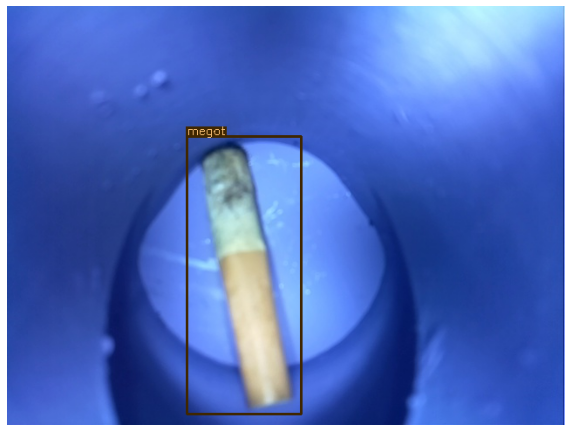

In [36]:
plt.figure(figsize=(10, 10))
plt.imshow(visualize(image_dict=dataset[0], classes=dataset.classes))
plt.axis("off")
plt.show()

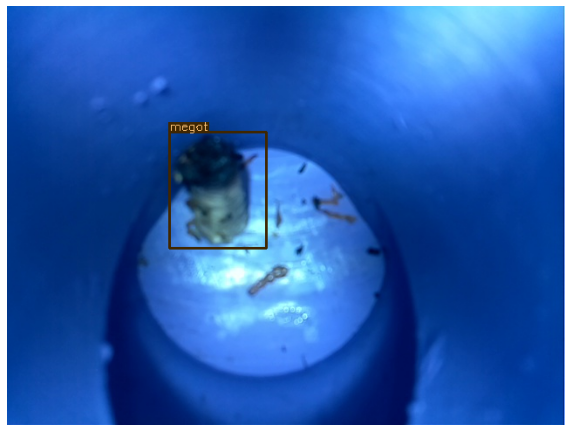

In [39]:
plt.figure(figsize=(10, 10))
plt.imshow(visualize(image_dict=dataset[146], classes=dataset.classes))
plt.axis("off")
plt.show()

# Objets PyTorch : Model, Optimizer, et LR Scheduler

Le modèle sous-jacent est `Cascade RCNN`. Voir [ici](https://arxiv.org/abs/1906.09756) pour les détails techniques.

In [40]:
model = build_model(cfg)
model = model.train()

In [41]:
optimizer = build_optimizer(cfg, model)

In [42]:
scheduler = build_lr_scheduler(cfg, optimizer)

# Checkpointer

In [43]:
checkpointer = DetectionCheckpointer(
    model, output_dir, optimizer=optimizer, scheduler=scheduler
)

L'objet `checkpointer` est utilisé pour charger les poids du modèle.

In [44]:
checkpointer.load(cfg.MODEL.WEIGHTS)

model_final_480dd8.pkl: 288MB [00:26, 10.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.0.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.1.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.2.cls_score.weight' to th

{'__author__': 'Detectron2 Model Zoo'}

# Entrainement du modèle

In [45]:
data_loader = build_detection_train_loader(cfg)

[08/23 13:01:40 d2.data.build]: Removed 0 images with no usable annotations. 147 images left.
[08/23 13:01:40 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   megot    | 147          |
|            |              |
[08/23 13:01:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[08/23 13:01:40 d2.data.build]: Using training sampler TrainingSampler
[08/23 13:01:40 d2.data.common]: Serializing 147 elements to byte tensors and concatenating them all ...
[08/23 13:01:40 d2.data.common]: Serialized dataset takes 0.04 MiB


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [46]:
writers = default_writers(output_dir, max_iter)

In [47]:
# EventStorage is used by EventWriters to dump results
with EventStorage() as storage:
    
    # Loop on the dataloader
    for data, iteration in zip(data_loader, range(max_iter)):
        storage.iter = iteration

        # Predict
        loss_dict = model(data)

        # Aggregate the losses into a total loss
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        # Store the losses
        storage.put_scalars(total_loss=losses, **loss_dict)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Store the lr
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        
        scheduler.step()

        # Write results
        if (iteration + 1) % 20 == 0 or iteration == max_iter - 1:
            for writer in writers:
                writer.write()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)

[08/23 13:02:01 d2.utils.events]:  iter: 19  total_loss: 8.508  loss_cls_stage0: 2.105  loss_box_reg_stage0: 0.2642  loss_cls_stage1: 2.294  loss_box_reg_stage1: 0.4352  loss_cls_stage2: 2.176  loss_box_reg_stage2: 0.5727  loss_mask: 0.6855  loss_rpn_cls: 0.001802  loss_rpn_loc: 0.003925  lr: 3.6333e-05  max_mem: 1762M
[08/23 13:02:14 d2.utils.events]:  eta: 0:52:12  iter: 39  total_loss: 5.921  loss_cls_stage0: 1.189  loss_box_reg_stage0: 0.2051  loss_cls_stage1: 1.329  loss_box_reg_stage1: 0.3807  loss_cls_stage2: 1.256  loss_box_reg_stage2: 0.6372  loss_mask: 0.6291  loss_rpn_cls: 0.001079  loss_rpn_loc: 0.004877  lr: 7.2474e-05  max_mem: 1762M
[08/23 13:02:27 d2.utils.events]:  eta: 0:52:21  iter: 59  total_loss: 2.728  loss_cls_stage0: 0.4074  loss_box_reg_stage0: 0.1405  loss_cls_stage1: 0.432  loss_box_reg_stage1: 0.2395  loss_cls_stage2: 0.5057  loss_box_reg_stage2: 0.421  loss_mask: 0.5468  loss_rpn_cls: 0.001274  loss_rpn_loc: 0.003573  lr: 0.00010861  max_mem: 1762M
[08/23 1

In [54]:
%%shell

ls output_cascade_mask_rcnn

birds_for_change_coco_format.json		    instances_predictions.pth
birds_for_change_coco_format.json.lock		    log.txt
coco_instances_results.json			    metrics.json
events.out.tfevents.1629723706.9f19391b4abd.1832.0


# Evaluation du modèle

In [49]:
data_loader = build_detection_test_loader(cfg, dataset_name)

[08/23 13:58:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[08/23 13:58:04 d2.data.common]: Serializing 147 elements to byte tensors and concatenating them all ...
[08/23 13:58:04 d2.data.common]: Serialized dataset takes 0.04 MiB


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


L'objet `COCOEvaluator` peut calculer les métriques pertinentes (i.e. `mAP`) sur le jeu de données.

In [50]:
evaluator = COCOEvaluator(dataset_name, output_dir=output_dir)

[08/23 13:58:04 d2.evaluation.coco_evaluation]: 'birds_for_change' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[08/23 13:58:04 d2.data.datasets.coco]: Converting annotations of dataset 'birds_for_change' to COCO format ...)
[08/23 13:58:04 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[08/23 13:58:05 d2.data.datasets.coco]: Conversion finished, #images: 147, #annotations: 147
[08/23 13:58:05 d2.data.datasets.coco]: Caching COCO format annotations at 'output_cascade_mask_rcnn/birds_for_change_coco_format.json' ...


In [51]:
results = inference_on_dataset(model, data_loader, evaluator)

[08/23 13:58:05 d2.evaluation.evaluator]: Start inference on 147 batches


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[08/23 13:58:10 d2.evaluation.evaluator]: Inference done 11/147. Dataloading: 0.0020 s/iter. Inference: 0.4528 s/iter. Eval: 0.0021 s/iter. Total: 0.4570 s/iter. ETA=0:01:02
[08/23 13:58:15 d2.evaluation.evaluator]: Inference done 22/147. Dataloading: 0.0025 s/iter. Inference: 0.4563 s/iter. Eval: 0.0021 s/iter. Total: 0.4612 s/iter. ETA=0:00:57
[08/23 13:58:20 d2.evaluation.evaluator]: Inference done 33/147. Dataloading: 0.0024 s/iter. Inference: 0.4554 s/iter. Eval: 0.0021 s/iter. Total: 0.4602 s/iter. ETA=0:00:52
[08/23 13:58:25 d2.evaluation.evaluator]: Inference done 44/147. Dataloading: 0.0024 s/iter. Inference: 0.4548 s/iter. Eval: 0.0021 s/iter. Total: 0.4595 s/iter. ETA=0:00:47
[08/23 13:58:30 d2.evaluation.evaluator]: Inference done 55/147. Dataloading: 0.0024 s/iter. Inference: 0.4541 s/iter. Eval: 0.0022 s/iter. Total: 0.4589 s/iter. ETA=0:00:42
[08/23 13:58:35 d2.evaluation.evaluator]: Inference done 66/147. Dataloading: 0.0024 s/iter. Inference: 0.4547 s/iter. Eval: 0.002

# Inference

Voyons comment le modèle prédit sur des images. Ici, il conviendrait d'avoir un jeu d'images non vues durant l'apprentissage.

In [55]:
test_dataset = BirdsForChangeDataset(root=".", load_images=True)

In [56]:
model = model.eval()

In [57]:
def infer(model, image):
    height, width, _ = image.shape
    inputs = {
        "image": torch.as_tensor(image.astype("float32").transpose(2, 0, 1)),
        "height": height,
        "width": width
    }
    with torch.no_grad():
        outputs = model([inputs])[0]
    instances = outputs["instances"].to("cpu")
    results = instances.get_fields()
    boxes = results["pred_boxes"]
    scores = results['scores']
    pred_classes = results["pred_classes"]
    return {
        "image": image,
        "annotations": [
            {
                "bbox": [int(b) for b in box],
                "category_id": int(pred),
                "score": score
            }
            for box, pred, score in zip(boxes, pred_classes, scores)
        ]
    }

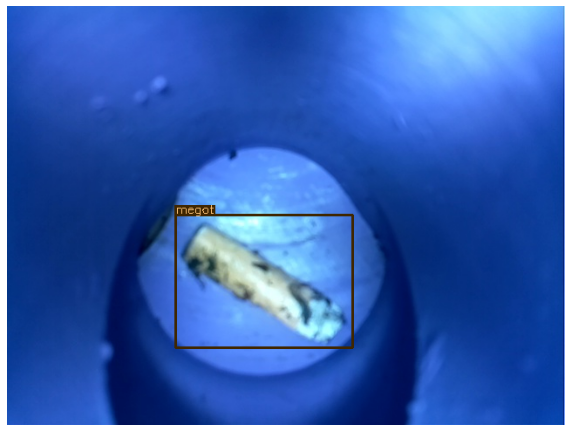

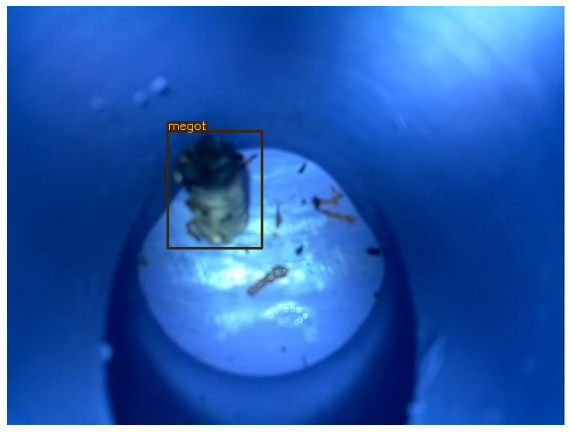

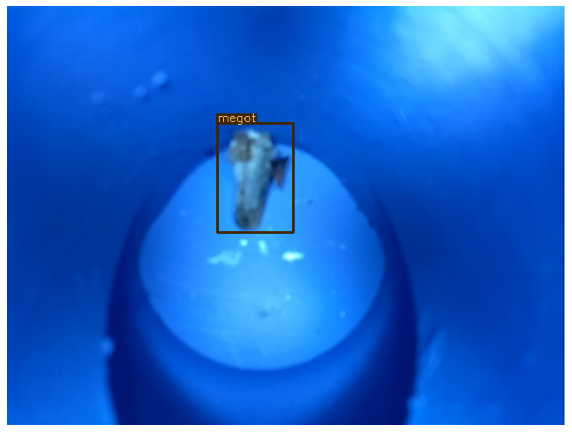

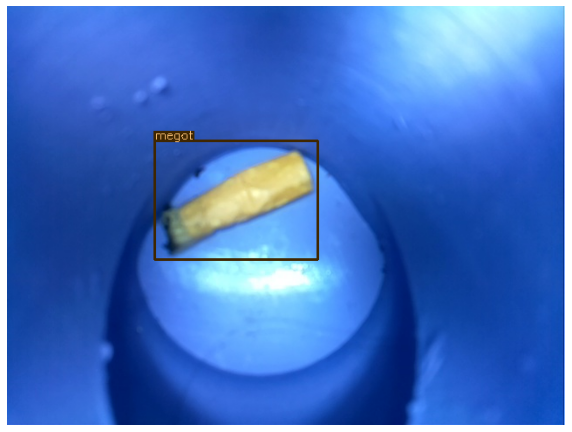

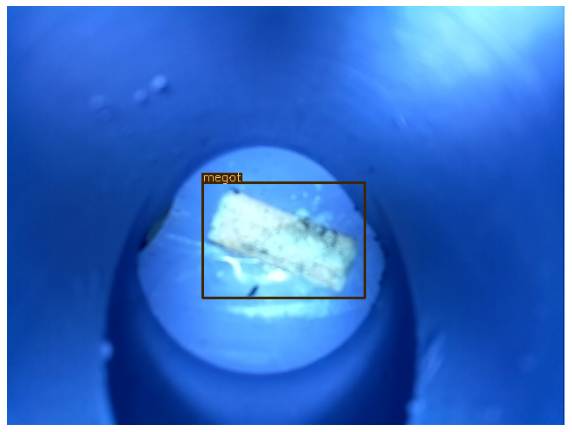

In [65]:
for i in [41, 146, 118, 101, 91]:
    image_dict = infer(model, test_dataset[i]["image"])
    image = visualize(image_dict=image_dict, classes=dataset.classes, threshold=0.7)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

That's it !